In [1]:
'''Deep Dreaming in Keras.
Run the script with:
```
python deep_dream.py path_to_your_base_image.jpg prefix_for_results
```
e.g.:
```
python deep_dream.py img/mypic.jpg results/dream
```
'''

'Deep Dreaming in Keras.\nRun the script with:\n```\npython deep_dream.py path_to_your_base_image.jpg prefix_for_results\n```\ne.g.:\n```\npython deep_dream.py img/mypic.jpg results/dream\n```\n'

In [2]:
from __future__ import print_function

import numpy as np
import scipy
import argparse

from keras.applications import inception_v3
from keras import backend as K

Using TensorFlow backend.


In [3]:
from keras.preprocessing.image import load_img, img_to_array

In [4]:
from matplotlib import pylab as plt

In [5]:
# parser = argparse.ArgumentParser(description='Deep Dreams with Keras.')
# parser.add_argument('base_image_path', metavar='base', type=str,
#                     help='Path to the image to transform.')
# parser.add_argument('result_prefix', metavar='res_prefix', type=str,
#                     help='Prefix for the saved results.')

In [6]:
# args = parser.parse_args()
# base_image_path = args.base_image_path
# result_prefix = args.result_prefix

In [7]:
base_image_path = 'input/fujiyuu75.jpg'
result_prefix = '.'

In [8]:
# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
    },
}

In [9]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [10]:
K.set_learning_phase(0)

# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
dream = model.input
print('Model loaded.')

Model loaded.


In [11]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [12]:
# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

In [13]:
# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

In [14]:
# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

In [15]:
def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [16]:
"""Process:
- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.
To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.
"""

'Process:\n- Load the original image.\n- Define a number of processing scales (i.e. image shapes),\n    from smallest to largest.\n- Resize the original image to the smallest scale.\n- For every scale, starting with the smallest (i.e. current one):\n    - Run gradient ascent\n    - Upscale image to the next scale\n    - Reinject the detail that was lost at upscaling time\n- Stop when we are back to the original size.\nTo obtain the detail lost during upscaling, we simply\ntake the original image, shrink it down, upscale it,\nand compare the result to the (resized) original image.\n'

In [17]:
# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 10.

In [18]:
img = preprocess_image(base_image_path)
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

In [19]:
for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

Processing image shape (204, 204)
..Loss value at 0 : 0.7242256
..Loss value at 1 : 0.9851192
..Loss value at 2 : 1.2754962
..Loss value at 3 : 1.5164553
..Loss value at 4 : 1.7589525
..Loss value at 5 : 1.953479
..Loss value at 6 : 2.1446576
..Loss value at 7 : 2.3428352
..Loss value at 8 : 2.6055777
..Loss value at 9 : 2.7571661
..Loss value at 10 : 2.9316099
..Loss value at 11 : 3.13232
..Loss value at 12 : 3.3362556
..Loss value at 13 : 3.511788
..Loss value at 14 : 3.562809
..Loss value at 15 : 3.7554426
..Loss value at 16 : 3.9286551
..Loss value at 17 : 4.079861
..Loss value at 18 : 4.1858735
..Loss value at 19 : 4.386231
Processing image shape (285, 285)
..Loss value at 0 : 1.2503164
..Loss value at 1 : 1.8669627
..Loss value at 2 : 2.271342
..Loss value at 3 : 2.5679243
..Loss value at 4 : 2.8686676
..Loss value at 5 : 3.1297853
..Loss value at 6 : 3.415842
..Loss value at 7 : 3.6879394
..Loss value at 8 : 3.9176557
..Loss value at 9 : 4.1191463
..Loss value at 10 : 4.391572
.

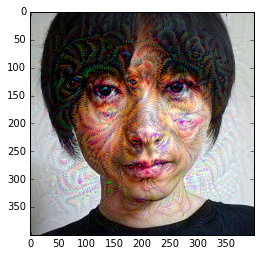

In [23]:
plt.imshow( deprocess_image(np.copy(img)))

In [24]:
import cv2